## Pip Install

In [1]:
#cell 1
!pip install numpy pandas librosa matplotlib seaborn scikit-learn keras resampy

## Import Libraries

In [2]:
#cell 2
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, BatchNormalization, Dropout,
                                     Flatten, Dense, LSTM, Bidirectional, GlobalAveragePooling1D, Input, Layer)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow as tf
import random


## Import Data

In [3]:
#cell 3
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#cell 4
speech_path = '/content/drive/MyDrive/mars/Audio_Speech_Actors_01-24'
song_path = '/content/drive/MyDrive/mars/Audio_Song_Actors_01-24'

## Focul Loss

In [5]:
#cell 5
def categorical_focal_loss(gamma=2., alpha=.25):
    def focal_loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss

## Emotions

In [6]:
#cell 6
emotion_dict = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

## Extract Features

In [7]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=3, offset=0, sr=22050)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=60, hop_length=512)
    target_length = 130
    if mfcc.shape[1] < target_length:
        pad_width = target_length - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :target_length]
    return mfcc.T

In [8]:
features = []

print("Starting Feature Extraction Process...\n")

print("Processing Speech Files...")
for folder in os.listdir(speech_path):
    print(f"Processing Speech Actor Folder: {folder}")
    for file in os.listdir(os.path.join(speech_path, folder)):
        file_path = os.path.join(speech_path, folder, file)
        emotion_label = emotion_dict[file.split('-')[2]]

        features.append([extract_features(file_path), emotion_label])

print("\nFinished processing Speech Files.\n")

print("Processing Song Files...")
for folder in os.listdir(song_path):
    print(f"Processing Song Actor Folder: {folder}")
    for file in os.listdir(os.path.join(song_path, folder)):
        file_path = os.path.join(song_path, folder, file)
        emotion_label = emotion_dict[file.split('-')[2]]

        features.append([extract_features(file_path), emotion_label])

print("\nFinished processing Song Files.\n")

print("Creating DataFrame from extracted features...")
df = pd.DataFrame(features, columns=['feature', 'emotion'])
print("DataFrame created successfully!")
print(f"Total samples: {len(df)}\n")

Starting Feature Extraction Process...

Processing Speech Files...
Processing Speech Actor Folder: Actor_05
Processing Speech Actor Folder: Actor_03
Processing Speech Actor Folder: Actor_09
Processing Speech Actor Folder: Actor_06
Processing Speech Actor Folder: Actor_08
Processing Speech Actor Folder: Actor_04
Processing Speech Actor Folder: Actor_02
Processing Speech Actor Folder: Actor_01
Processing Speech Actor Folder: Actor_07
Processing Speech Actor Folder: Actor_11
Processing Speech Actor Folder: Actor_16
Processing Speech Actor Folder: Actor_17
Processing Speech Actor Folder: Actor_12
Processing Speech Actor Folder: Actor_18
Processing Speech Actor Folder: Actor_14
Processing Speech Actor Folder: Actor_15
Processing Speech Actor Folder: Actor_13
Processing Speech Actor Folder: Actor_10
Processing Speech Actor Folder: Actor_19
Processing Speech Actor Folder: Actor_20
Processing Speech Actor Folder: Actor_24
Processing Speech Actor Folder: Actor_22
Processing Speech Actor Folder:

## Data prepration and scaling

In [ ]:
X = np.array([i for i in df['feature']])
y = np.array(df['emotion'].tolist())

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

# Scale training and test sets separately
num_samples_train, time_steps, n_features = X_train.shape
X_train_flat = X_train.reshape(num_samples_train * time_steps, n_features)

# Fit scaler
scaler = StandardScaler()
X_train_scaled_flat = scaler.fit_transform(X_train_flat)
X_train_scaled = X_train_scaled_flat.reshape(num_samples_train, time_steps, n_features)

# Transform test data
num_samples_test = X_test.shape[0]
X_test_flat = X_test.reshape(num_samples_test * time_steps, n_features)
X_test_scaled_flat = scaler.transform(X_test_flat)  # Only transform, don't fit
X_test_scaled = X_test_scaled_flat.reshape(num_samples_test, time_steps, n_features)

print("Classes:", label_encoder.classes_)
print("Training shape:", X_train_scaled.shape)
print("Test shape:", X_test_scaled.shape)

Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
Training shape: (1961, 130, 60)
Test shape: (491, 130, 60)


## Weights

In [ ]:
y_train_encoded = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weight_dict = dict(enumerate(class_weights))

## Data Augmentation

In [ ]:
import random

def add_gaussian_noise(mfcc, noise_factor=0.01):
    noise = np.random.normal(0, noise_factor, mfcc.shape)
    return mfcc + noise

def time_shift(mfcc, shift_max=5):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(mfcc, shift, axis=0)

def spec_augment(mfcc, freq_mask_param=10, time_mask_param=10):
    mfcc = mfcc.copy()

    # Frequency
    freq_mask = np.random.randint(0, freq_mask_param)
    freq_start = np.random.randint(0, mfcc.shape[1] - freq_mask)
    mfcc[:, freq_start:freq_start+freq_mask] = 0

    # Time
    time_mask = np.random.randint(0, time_mask_param)
    time_start = np.random.randint(0, mfcc.shape[0] - time_mask)
    mfcc[time_start:time_start+time_mask, :] = 0

    return mfcc

def pitch_shift(mfcc, sr=22050, n_steps=2):
    mfcc = mfcc.T  # shape: (n_mfcc, time) for inverse
    S = librosa.feature.inverse.mfcc_to_mel(mfcc, sr=sr)
    y = librosa.feature.inverse.mel_to_audio(S, sr=sr)
    y_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-n_steps, n_steps))
    mfcc_shifted = librosa.feature.mfcc(y=y_shifted, sr=sr, n_mfcc=mfcc.shape[0])
    return mfcc_shifted.T[:mfcc.shape[1], :mfcc.shape[0]].T  # adjust (to match original)

def augment_feature_array_all_classes(X, y, num_augmented_samples=2, sr=22050):
    X_augmented = []
    y_augmented = []

    for i in range(len(X)):
        for _ in range(num_augmented_samples):
            augmented = X[i]

            # Randomly picking augmentation
            choice = random.choice(['noise', 'time_shift', 'spec_augment'])

            if choice == 'noise':
                augmented = add_gaussian_noise(augmented)
            elif choice == 'time_shift':
                augmented = time_shift(augmented)
            elif choice == 'spec_augment':
                augmented = spec_augment(augmented)
            # elif choice == 'pitch_shift':
            #     augmented = pitch_shift(augmented.T, sr=sr).T #extra processing time

            X_augmented.append(augmented)
            y_augmented.append(y[i])

    X_combined = np.concatenate([X, np.array(X_augmented)], axis=0)
    y_combined = np.concatenate([y, np.array(y_augmented)], axis=0)

    return X_combined, y_combined


In [ ]:
X_train_aug, y_train_aug = augment_feature_array_all_classes(X_train_scaled, y_train)

print("Balanced Data Augmentation applied!")
print("Original training samples:", X_train_scaled.shape[0])
print("Augmented training samples:", X_train_aug.shape[0])

Balanced Data Augmentation applied!
Original training samples: 1961
Augmented training samples: 5883


In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, MaxPooling1D, Dropout,
    Bidirectional, LSTM, Dense, SpatialDropout1D, LayerNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.regularizers import l2


## Model

In [ ]:
class EnhancedAttention(Layer):
    def __init__(self, units=128, **kwargs):
        super(EnhancedAttention, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform"
        )
        self.b = self.add_weight(
            name="att_bias",
            shape=(self.units,),
            initializer="zeros"
        )
        self.u = self.add_weight(
            name="att_context",
            shape=(self.units,),
            initializer="glorot_uniform"
        )
        super(EnhancedAttention, self).build(input_shape)

    def call(self, x):
        uit = K.tanh(K.dot(x, self.W) + self.b)
        ait = K.sum(uit * self.u, axis=2)
        ait = K.softmax(ait, axis=1)

        ait = K.expand_dims(ait, -1)
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


num_classes = y_train.shape[1]

model = Sequential([
    Input(shape=(X_train_aug.shape[1], X_train_aug.shape[2])),

    # First Conv Block - More filters, better regularization
    Conv1D(256, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    SpatialDropout1D(0.2),
    MaxPooling1D(2),

    # Second Conv Block
    Conv1D(128, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    SpatialDropout1D(0.2),
    MaxPooling1D(2),

    # Third Conv Block
    Conv1D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    SpatialDropout1D(0.2),

    # Enhanced LSTM
    Bidirectional(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),
    LayerNormalization(),

    # Enhanced Attention
    EnhancedAttention(units=128),

    # Enhanced Dense layers
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    # Output layer wit softmax
    Dense(num_classes, activation='softmax')
])
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=0.001,
    first_decay_steps=30,
    t_mul=2.0,
    m_mul=0.9,
    alpha=0.0
)

optimizer = Adam(learning_rate=lr_schedule, clipnorm=1.0)


model.compile(
    optimizer=optimizer,
    loss=categorical_focal_loss(gamma=2),
    metrics=['accuracy', 'precision', 'recall']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 130, 256)       │        46,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 130, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ (None, 130, 256)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 65, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 65, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 65, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ (None, 65, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 32, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_5             │ (None, 32, 64)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32, 512)        │       657,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 32, 512)        │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enhanced_attention_1            │ (None, 512)            │        65,792 │
│ (EnhancedAttention)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             

 Total params: 1,294,536 (4.94 MB)

 Trainable params: 1,292,104 (4.93 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


In [ ]:
history = model.fit(
    X_train_aug, y_train_aug,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 67s 240ms/step - accuracy: 0.2376 - loss: 1.7664 - precision: 0.2743 - recall: 0.1530 - val_accuracy: 0.5499 - val_loss: 1.3890 - val_precision: 0.6891 - val_recall: 0.4379
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 75s 226ms/step - accuracy: 0.3964 - loss: 1.4810 - precision: 0.4786 - recall: 0.2923 - val_accuracy: 0.5967 - val_loss: 1.2636 - val_precision: 0.7203 - val_recall: 0.5193
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 81s 224ms/step - accuracy: 0.4779 - loss: 1.3057 - precision: 0.5796 - recall: 0.3579 - val_accuracy: 0.5804 - val_loss: 1.1890 - val_precision: 0.6632 - val_recall: 0.5132
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 82s 225ms/step - accuracy: 0.5386 - loss: 1.1445 - precision: 0.6511 - recall: 0.4141 - val_accuracy: 0.6599 - val_loss: 1.0092 - val_precision: 0.7806 - val_recall: 0.5723
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 42s 225ms/step - accuracy: 0.5866 - loss: 1.0156 - precision: 0.6886 - recall: 0.4478 - val_accuracy: 0

## Eval

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7997 - loss: 0.1570 - precision: 0.8257 - recall: 0.7903
Test Accuracy: 82.69%
Test Precision: 0.8450
Test Recall: 0.8106
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.86      0.89      0.88        75
        calm       0.90      0.85      0.88        75
     disgust       0.76      0.79      0.78        39
     fearful       0.79      0.72      0.76        75
       happy       0.88      0.87      0.87        75
     neutral       0.80      0.92      0.85        38
         sad       0.81      0.72      0.76        75
   surprised       0.75      0.92      0.83        39

    accuracy                           0.83       491
   macro avg       0.82      0.84      0.82       491
weighted avg       0.83      0.83      0.83       491


Confusion Matrix:
[[67  1  2  0  0  0  2  3]
 [ 0 64  0  0  2  5  4  0]
 [ 4  0 31  0  2  0  1  1]
 [ 5  0 

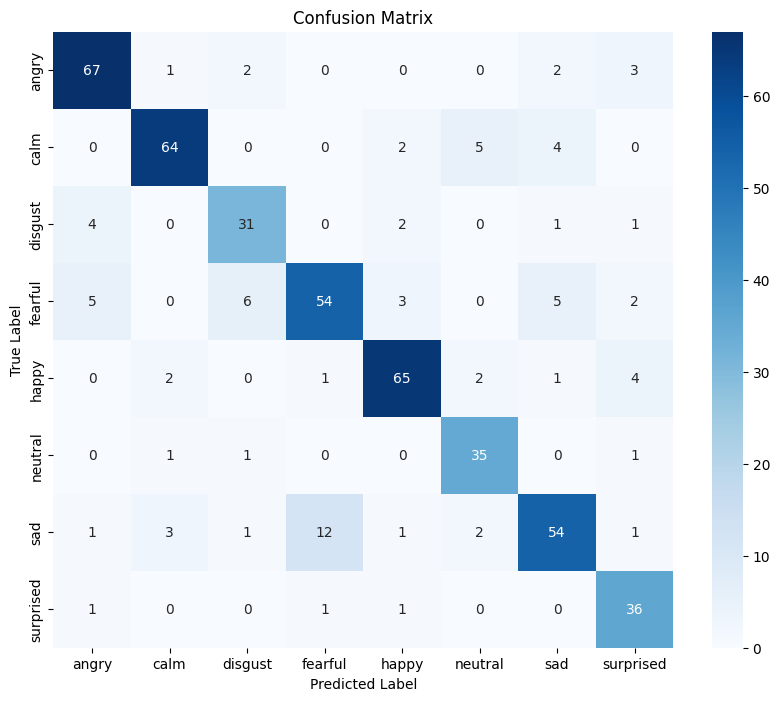


F1 Score (Weighted): 0.8259
F1 Score (Macro): 0.8246


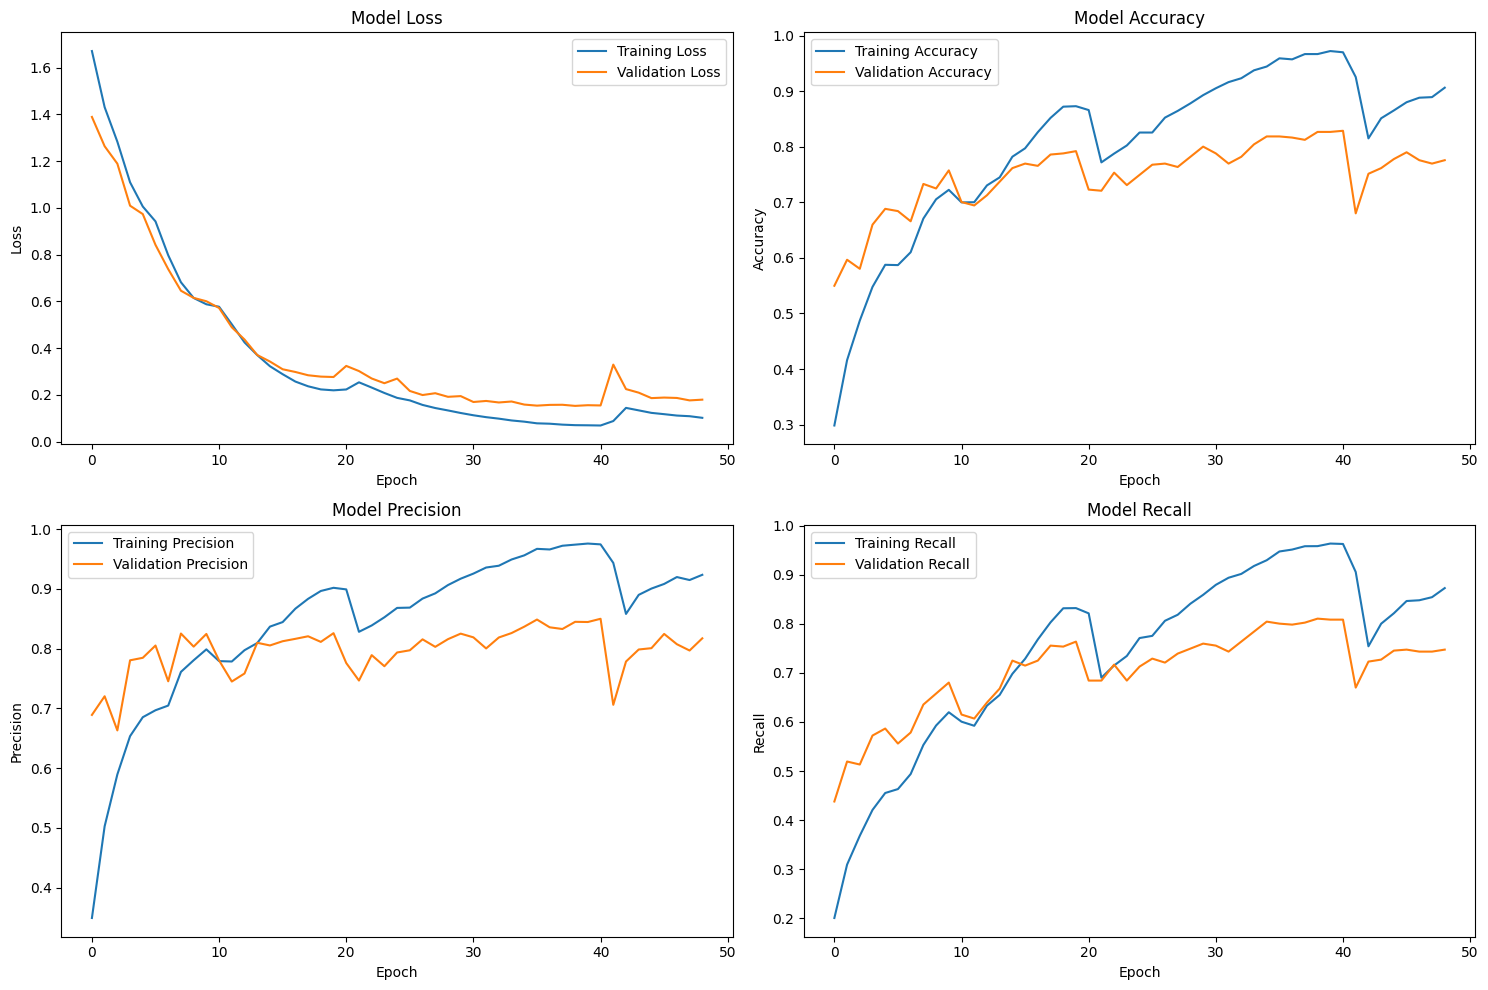


FINAL RESULTS SUMMARY
Test Accuracy: 82.69%
Test Precision: 0.8450
Test Recall: 0.8106
F1 Score (Weighted): 0.8259
F1 Score (Macro): 0.8246
Training stopped at epoch: 49


In [ ]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


f1_weighted = f1_score(y_true, y_pred_classes, average='weighted')
f1_macro = f1_score(y_true, y_pred_classes, average='macro')
print(f"\nF1 Score (Weighted): {f1_weighted:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")

# Plot training history
plt.figure(figsize=(15, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

#final summary
print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"Training stopped at epoch: {len(history.history['loss'])}")
print("="*50)

Number of Correct Predictions per Class:
angry: 67 correct predictions
calm: 64 correct predictions
disgust: 31 correct predictions
fearful: 54 correct predictions
happy: 65 correct predictions
neutral: 35 correct predictions
sad: 54 correct predictions
surprised: 36 correct predictions


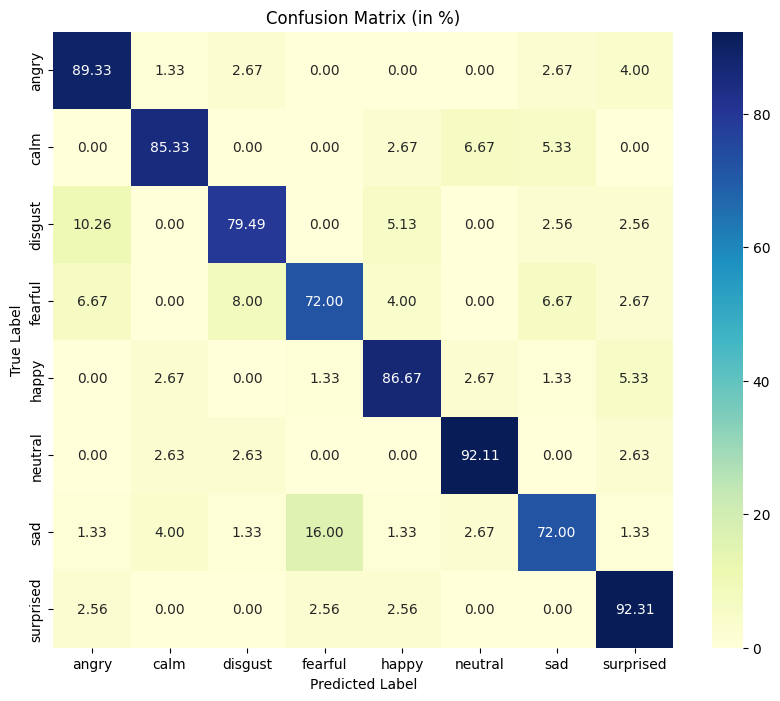


Total Correct Predictions: 406 out of 491
Overall Accuracy (calculated from CM): 82.69%


In [ ]:
correct_preds_per_class = np.diag(cm)

print("Number of Correct Predictions per Class:")
for idx, label in enumerate(label_encoder.classes_):
    print(f"{label}: {correct_preds_per_class[idx]} correct predictions")

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (in %)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

total_correct = np.trace(cm)
total_samples = np.sum(cm)
overall_accuracy = total_correct / total_samples * 100
print(f"\nTotal Correct Predictions: {total_correct} out of {total_samples}")
print(f"Overall Accuracy (calculated from CM): {overall_accuracy:.2f}%")


## Save model

In [ ]:
import joblib

save_path = '/content/drive/MyDrive/mars'

model.save(f'{save_path}/emotion_model.h5')

# Save preprocessing objects
joblib.dump(scaler, f'{save_path}/scaler.pkl')
joblib.dump(label_encoder, f'{save_path}/label_encoder.pkl')
model.save(f'{save_path}/emotion_model.keras')
print(f"Model and artifacts saved in '{save_path}' directory!")
